# Analisi California Housing

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from base_data_handler import BaseDataHandler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [134]:
# Caricamento dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['med_house_val'] = housing.target  

# Creo l'handler
handler = BaseDataHandler(df=df)
_ = handler.try_clean_column_names()



In [135]:
# Rimozione outlier
mask = handler.get_outliers_df(upper_percentile=0.9, lower_percentile=0.09, method='percentile')
handler.df = handler.df[~mask]
handler.df.dropna(inplace=True)

In [ ]:
# Funzione per aggiungere popolazione per cella
def add_population_per_cell(df, lat_col="latitude", lon_col="longitude", pop_col="population",
                            lat_bin=0.1, lon_bin=0.1):
    df = df.copy()
    df["_lat_bin"] = (df[lat_col] // lat_bin) * lat_bin
    df["_lon_bin"] = (df[lon_col] // lon_bin) * lon_bin

    pop_map = (
        df.groupby(["_lat_bin", "_lon_bin"])[pop_col]
        .sum()
        .reset_index()
        .rename(columns={pop_col: "pop_per_cell"})
    )

    df = df.merge(pop_map, on=["_lat_bin", "_lon_bin"], how="left")
    return df.drop(columns=["_lat_bin", "_lon_bin"])

handler.df = add_population_per_cell(handler.df)

# Funzione per classificare posizione (coast, valley, inland)
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)

def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def classify_location(lat, lon):
    coast_at_lat = _coast_lon(lat)
    coast_buffer = 1
    inland_shift = 2.3
    inland_at_lat = coast_at_lat + inland_shift

    if lon <= coast_at_lat + coast_buffer:
        return 2
    elif lon >= inland_at_lat:
        return 0
    else:
        return 1

_ = handler.try_add_col(target_col="position", func=lambda row: classify_location(row['latitude'], row['longitude']))


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  float64
 2   AveRooms       20640 non-null  float64
 3   AveBedrms      20640 non-null  float64
 4   Population     20640 non-null  float64
 5   AveOccup       20640 non-null  float64
 6   Latitude       20640 non-null  float64
 7   Longitude      20640 non-null  float64
 8   med_house_val  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [138]:
# Preparazione dati per il modello
X = handler.df.drop(columns=["med_house_val", "medinc", "population"])
y = handler.df["med_house_val"]

In [139]:
print(handler.df.columns)


Index(['medinc', 'houseage', 'averooms', 'avebedrms', 'population', 'aveoccup',
       'latitude', 'longitude', 'med_house_val', 'pop_per_cell', 'position'],
      dtype='object')


In [ ]:
# Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Divisione train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## LinearRegression

In [ ]:
# Creazione e addestramento modello LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predizione
y_pred_l = model.predict(X_test)

# Valutazione del modello
mse = mean_squared_error(y_test, y_pred_l)
r2 = r2_score(y_test, y_pred_l)
mae = mean_absolute_error(y_test, y_pred_l)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Mean Squared Error (MSE): 0.28
R^2 Score: 0.43
RMSE: 0.53
MAE: 0.41


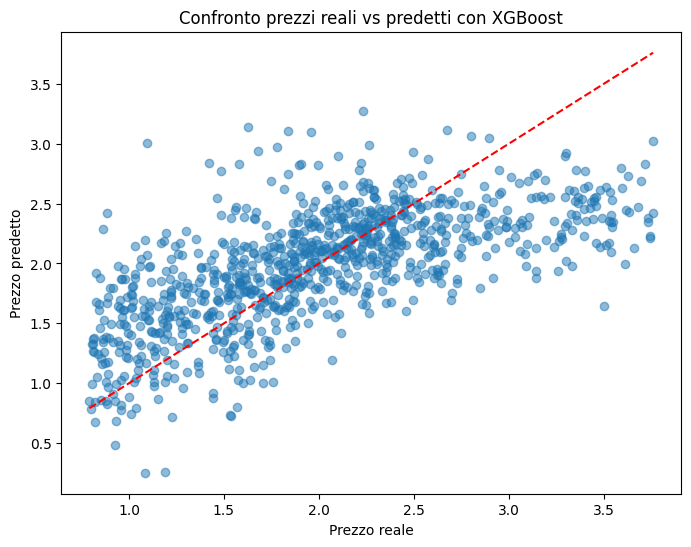

In [143]:
# Grafico confronto valori reali vs predetti
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_l, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prezzo reale")
plt.ylabel("Prezzo predetto")
plt.title("Confronto prezzi reali vs predetti con XGBoost")
plt.show()

## RandomForest

In [144]:
# Random Forest Regressor
model1 = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model1.fit(X_train, y_train)

# Predizione
y_pred1 = model1.predict(X_test)

# Valutazione
mse = mean_squared_error(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)
mae = mean_absolute_error(y_test, y_pred1)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.12
R² Score: 0.75
RMSE: 0.35
MAE: 0.25


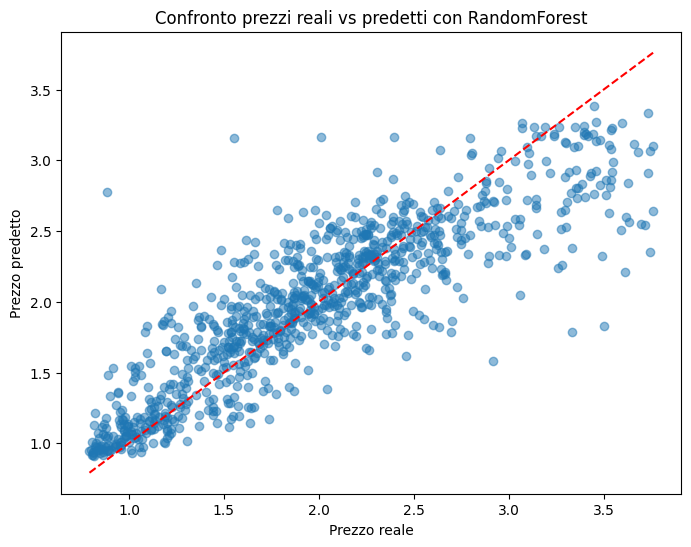

In [145]:
# Grafico confronto valori reali vs predetti
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Prezzo reale")
plt.ylabel("Prezzo predetto")
plt.title("Confronto prezzi reali vs predetti con RandomForest")
plt.show()

--- KNN Regressor ---
MSE: 0.250
R²: 0.500
MAE: 0.38
RMSE: 0.50
--- XGBoost Regressor ---
MSE: 0.113
R²: 0.774
MAE: 0.24
RMSE: 0.34


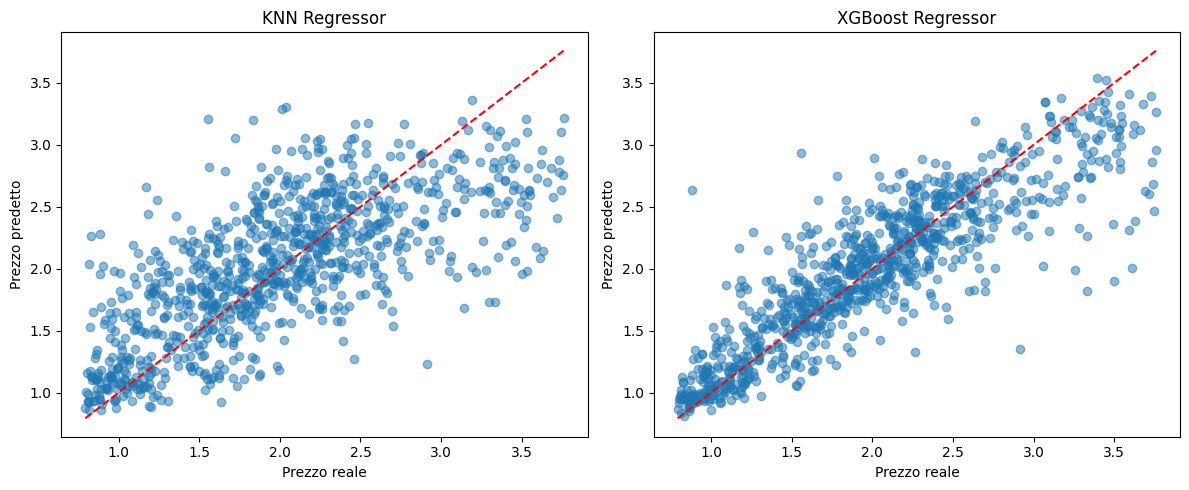

In [146]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Lista dei modelli da testare
models = [
    ("KNN Regressor", KNeighborsRegressor(n_neighbors=5)),
    ("XGBoost Regressor", XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42))
]

# Creiamo un figure con 1 riga e tante colonne quanti sono i modelli
fig, axes = plt.subplots(1, len(models), figsize=(12, 5))  # 1 riga, N colonne

for ax, (name, model) in zip(axes, models):
    # Addestramento
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred = model.predict(X_test)
    
    # Valutazione
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    
    print(f"--- {name} ---")
    print(f"MSE: {mse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Grafico valori reali vs predetti
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_xlabel("Prezzo reale")
    ax.set_ylabel("Prezzo predetto")
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()


In [147]:
""" # Grafici affiancati LinearRegression vs RandomForest
fig, axes = plt.subplots(1, 2, figsize=(16,6))  # 1 riga, 2 colonne

# Linear Regression
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel("Prezzo reale")
axes[0].set_ylabel("Prezzo predetto")
axes[0].set_title("Linear Regression")

# Random Forest
axes[1].scatter(y_test, y_pred1, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_xlabel("Prezzo reale")
axes[1].set_ylabel("Prezzo predetto")
axes[1].set_title("Random Forest")

plt.tight_layout()
plt.show()
 """

' # Grafici affiancati LinearRegression vs RandomForest\nfig, axes = plt.subplots(1, 2, figsize=(16,6))  # 1 riga, 2 colonne\n\n# Linear Regression\naxes[0].scatter(y_test, y_pred, alpha=0.5)\naxes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], \'r--\')\naxes[0].set_xlabel("Prezzo reale")\naxes[0].set_ylabel("Prezzo predetto")\naxes[0].set_title("Linear Regression")\n\n# Random Forest\naxes[1].scatter(y_test, y_pred1, alpha=0.5)\naxes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], \'r--\')\naxes[1].set_xlabel("Prezzo reale")\naxes[1].set_ylabel("Prezzo predetto")\naxes[1].set_title("Random Forest")\n\nplt.tight_layout()\nplt.show()\n '